In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set(style='darkgrid', context='notebook')
from matplotlib import pyplot as plt
from figures.plotting import annotate_corr_grid

metric_nshot = 'MRR (log)'
pooling_nshot = True
metric_columns = ['accuracy (top 1)', 'accuracy (top 5)', 'MRR']

metric_man = 'intra-dim'
dataset_man = 'imagenet21k'
pooling_man = True

In [6]:
data = pd.DataFrame()
for d, c in [('imagenet', 'linear'), ('imagenet', 'prototype'), 
             ('imagenet21k', 'linear'), ('imagenet21k', 'prototype')]:
    data_i = pd.read_csv(f'../results/n-shot|dataset:{d}|classifier:{c}|pooling:{pooling_nshot}.csv')
    if c == 'linear':
        data_i = data_i.drop('log likelihood', axis='columns')
        
    data_i = data_i.drop('i_repeat', axis='columns')
    data_i = data_i.groupby([c for c in data_i.columns if c not in metric_columns], as_index=False).mean()
    
    data_i = data_i.assign(classifier=c, dataset_nshot=d)
    
    data = data.append(data_i)

del data_i
    
for m in metric_columns:
    if 'log' not in m:
        data[f'{m} (log)'] = np.log(data[m])
        metric_columns.append(f'{m} (log)')

man_data = pd.read_csv(f'../results/manifolds|dataset:{dataset_man}|pooling:{pooling_man}.csv')
man_metric_columns = ['between-concept radius', 'within-concept radius (mean)', 'between-concept dimensionality', 'within-concept dimensionality (mean)', 
                      'signal (mean)', 'bias (mean)', 'other signal-noise-overlap (mean)', 'self signal-noise-overlap (mean)', 'signal-noise-ratio (mean)']
man_metric_label_map = {'between-concept dimensionality': 'inter-dim', 'between-concept radius': 'inter-radius', 
                        'bias (mean)': 'bias', 'signal (mean)': 'signal', 'signal-noise-ratio (mean)': 'snr', 
                        'other signal-noise-overlap (mean)': 'other-sno', 'self signal-noise-overlap (mean)': 'self-sno', 
                        'within-concept dimensionality (mean)': 'intra-dim', 'within-concept radius (mean)': 'intra-radius'}
man_metric_columns = [man_metric_label_map[m] for m in man_metric_columns]
man_data = man_data.rename(columns=man_metric_label_map)
man_metric_stds = [c for c in man_data.columns if '(std)' in c]
man_data = man_data.drop(columns=man_metric_stds)
        
data = pd.merge(data, man_data, 
                on=['architecture', 'task', 'kind', 'source', 'layer'])

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

data.head()

,n_train,layer,architecture,task,kind,source,accuracy (top 1),accuracy (top 5),MRR,classifier,...,MRR (log),inter-dim,inter-radius,bias,other-sno,self-sno,signal,snr,intra-dim,intra-radius
0,1,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.02792,0.12620,0.105830,linear,...,-2.245918,1.75092,0.536332,0.006812,16.719585,16.676098,4.03148,0.52946,3.316195,1.163732
1,5,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.03748,0.15500,0.123412,linear,...,-2.092224,1.75092,0.536332,0.006812,16.719585,16.676098,4.03148,0.52946,3.316195,1.163732
2,20,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.04500,0.18472,0.138450,linear,...,-1.977243,1.75092,0.536332,0.006812,16.719585,16.676098,4.03148,0.52946,3.316195,1.163732
3,50,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.04768,0.21772,0.153021,linear,...,-1.877180,1.75092,0.536332,0.006812,16.719585,16.676098,4.03148,0.52946,3.316195,1.163732
4,1,layer1.0.relu,ResNet18,Auto-Encoder,Self-Supervised,VVS,0.02612,0.11936,0.102201,prototype,...,-2.280817,1.75092,0.536332,0.006812,16.719585,16.676098,4.03148,0.52946,3.316195,1.163732


---
# Compare:
    1. In-Distribution vs. Out-of-Distribution classification
    2. Few-shot vs. Many-shot
    3. Linear classification vs. Prototype learning

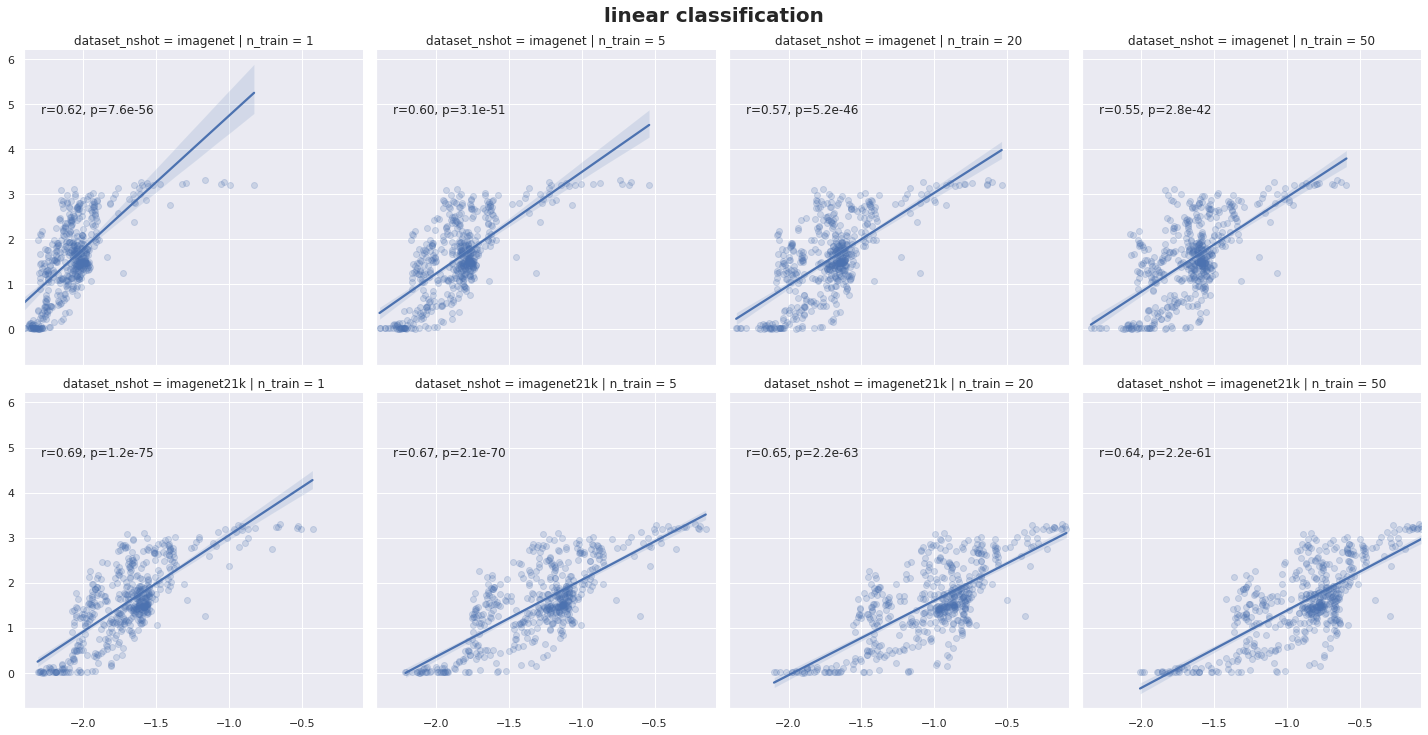

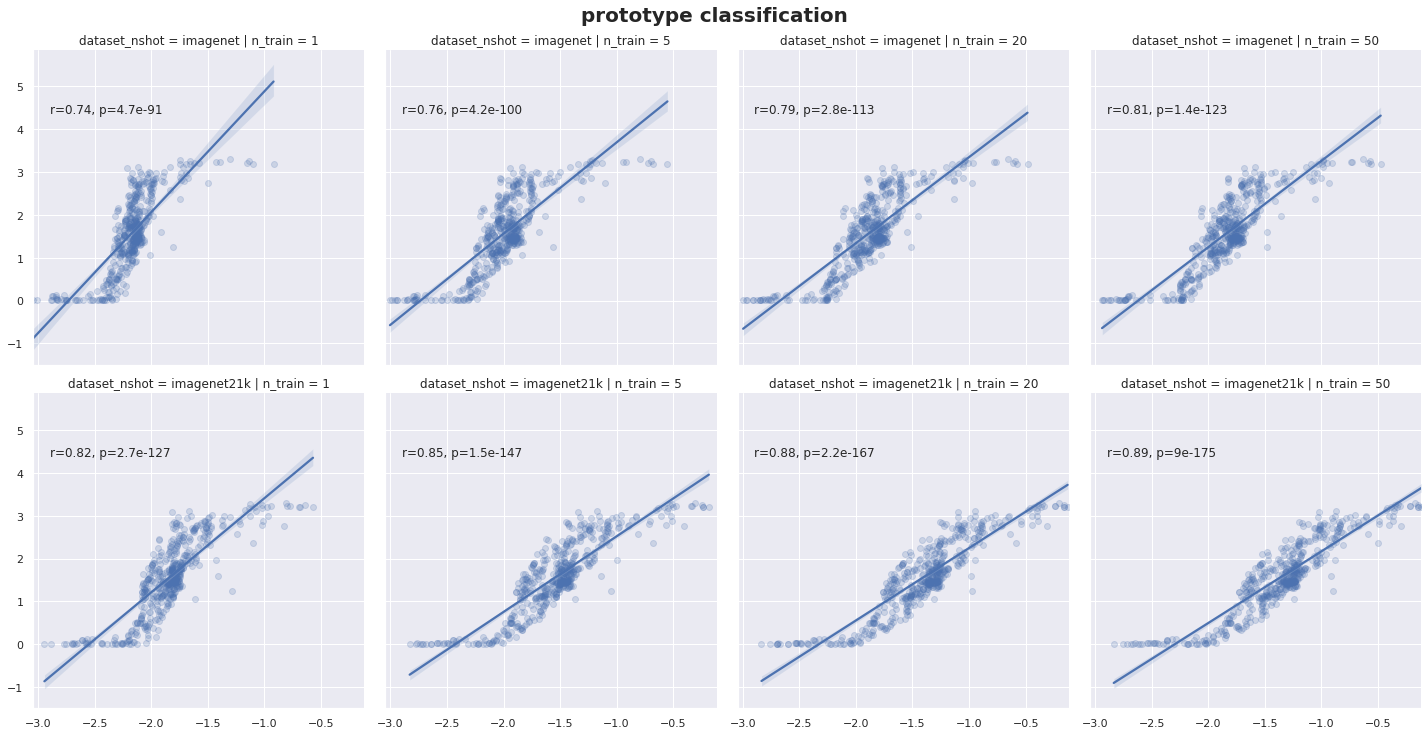

In [10]:
for c in ['linear', 'prototype']:
    g = sns.lmplot(data=data[data.classifier == c], x=metric_nshot, y=metric_man, col='n_train', row='dataset_nshot',
                   scatter_kws={'alpha':0.2}, sharex=True, sharey=True, height=5)
    annotate_corr_grid(g, x=metric_nshot, y=metric_man)
    fig = g.fig 
    fig.suptitle(f'{c} classification', fontsize=20, fontweight='bold', y=1.02)
    plt.show()

---
# Specific classification method and dataset 

In [12]:
classifier = 'linear'
dataset_nshot = 'imagenet21k'

data_cd = data[(data.classifier == classifier) & (data.dataset_nshot == dataset_nshot)]

## All models and layers

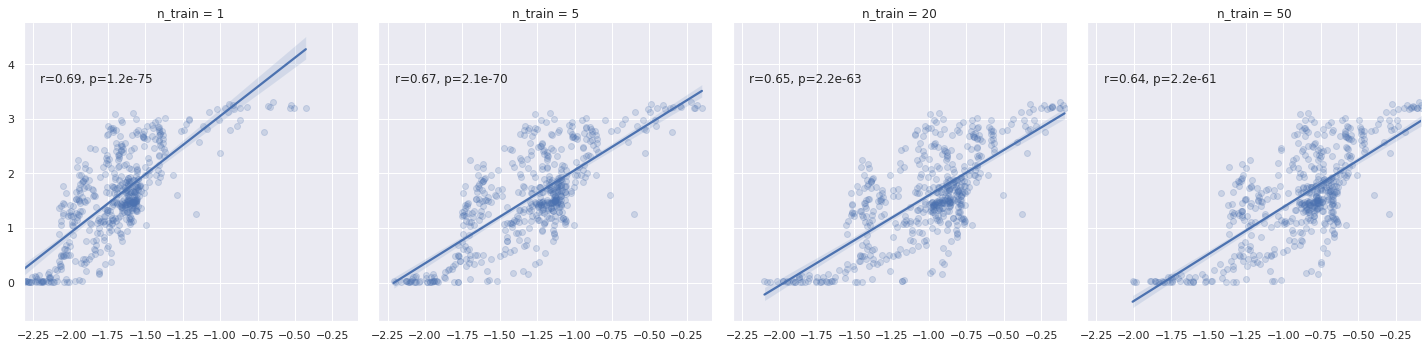

In [13]:
g = sns.lmplot(data=data_cd, x=metric_nshot, y=metric_man, col='n_train',
               scatter_kws={'alpha':0.2}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric_nshot, y=metric_man)
plt.show()

## ResNet 18

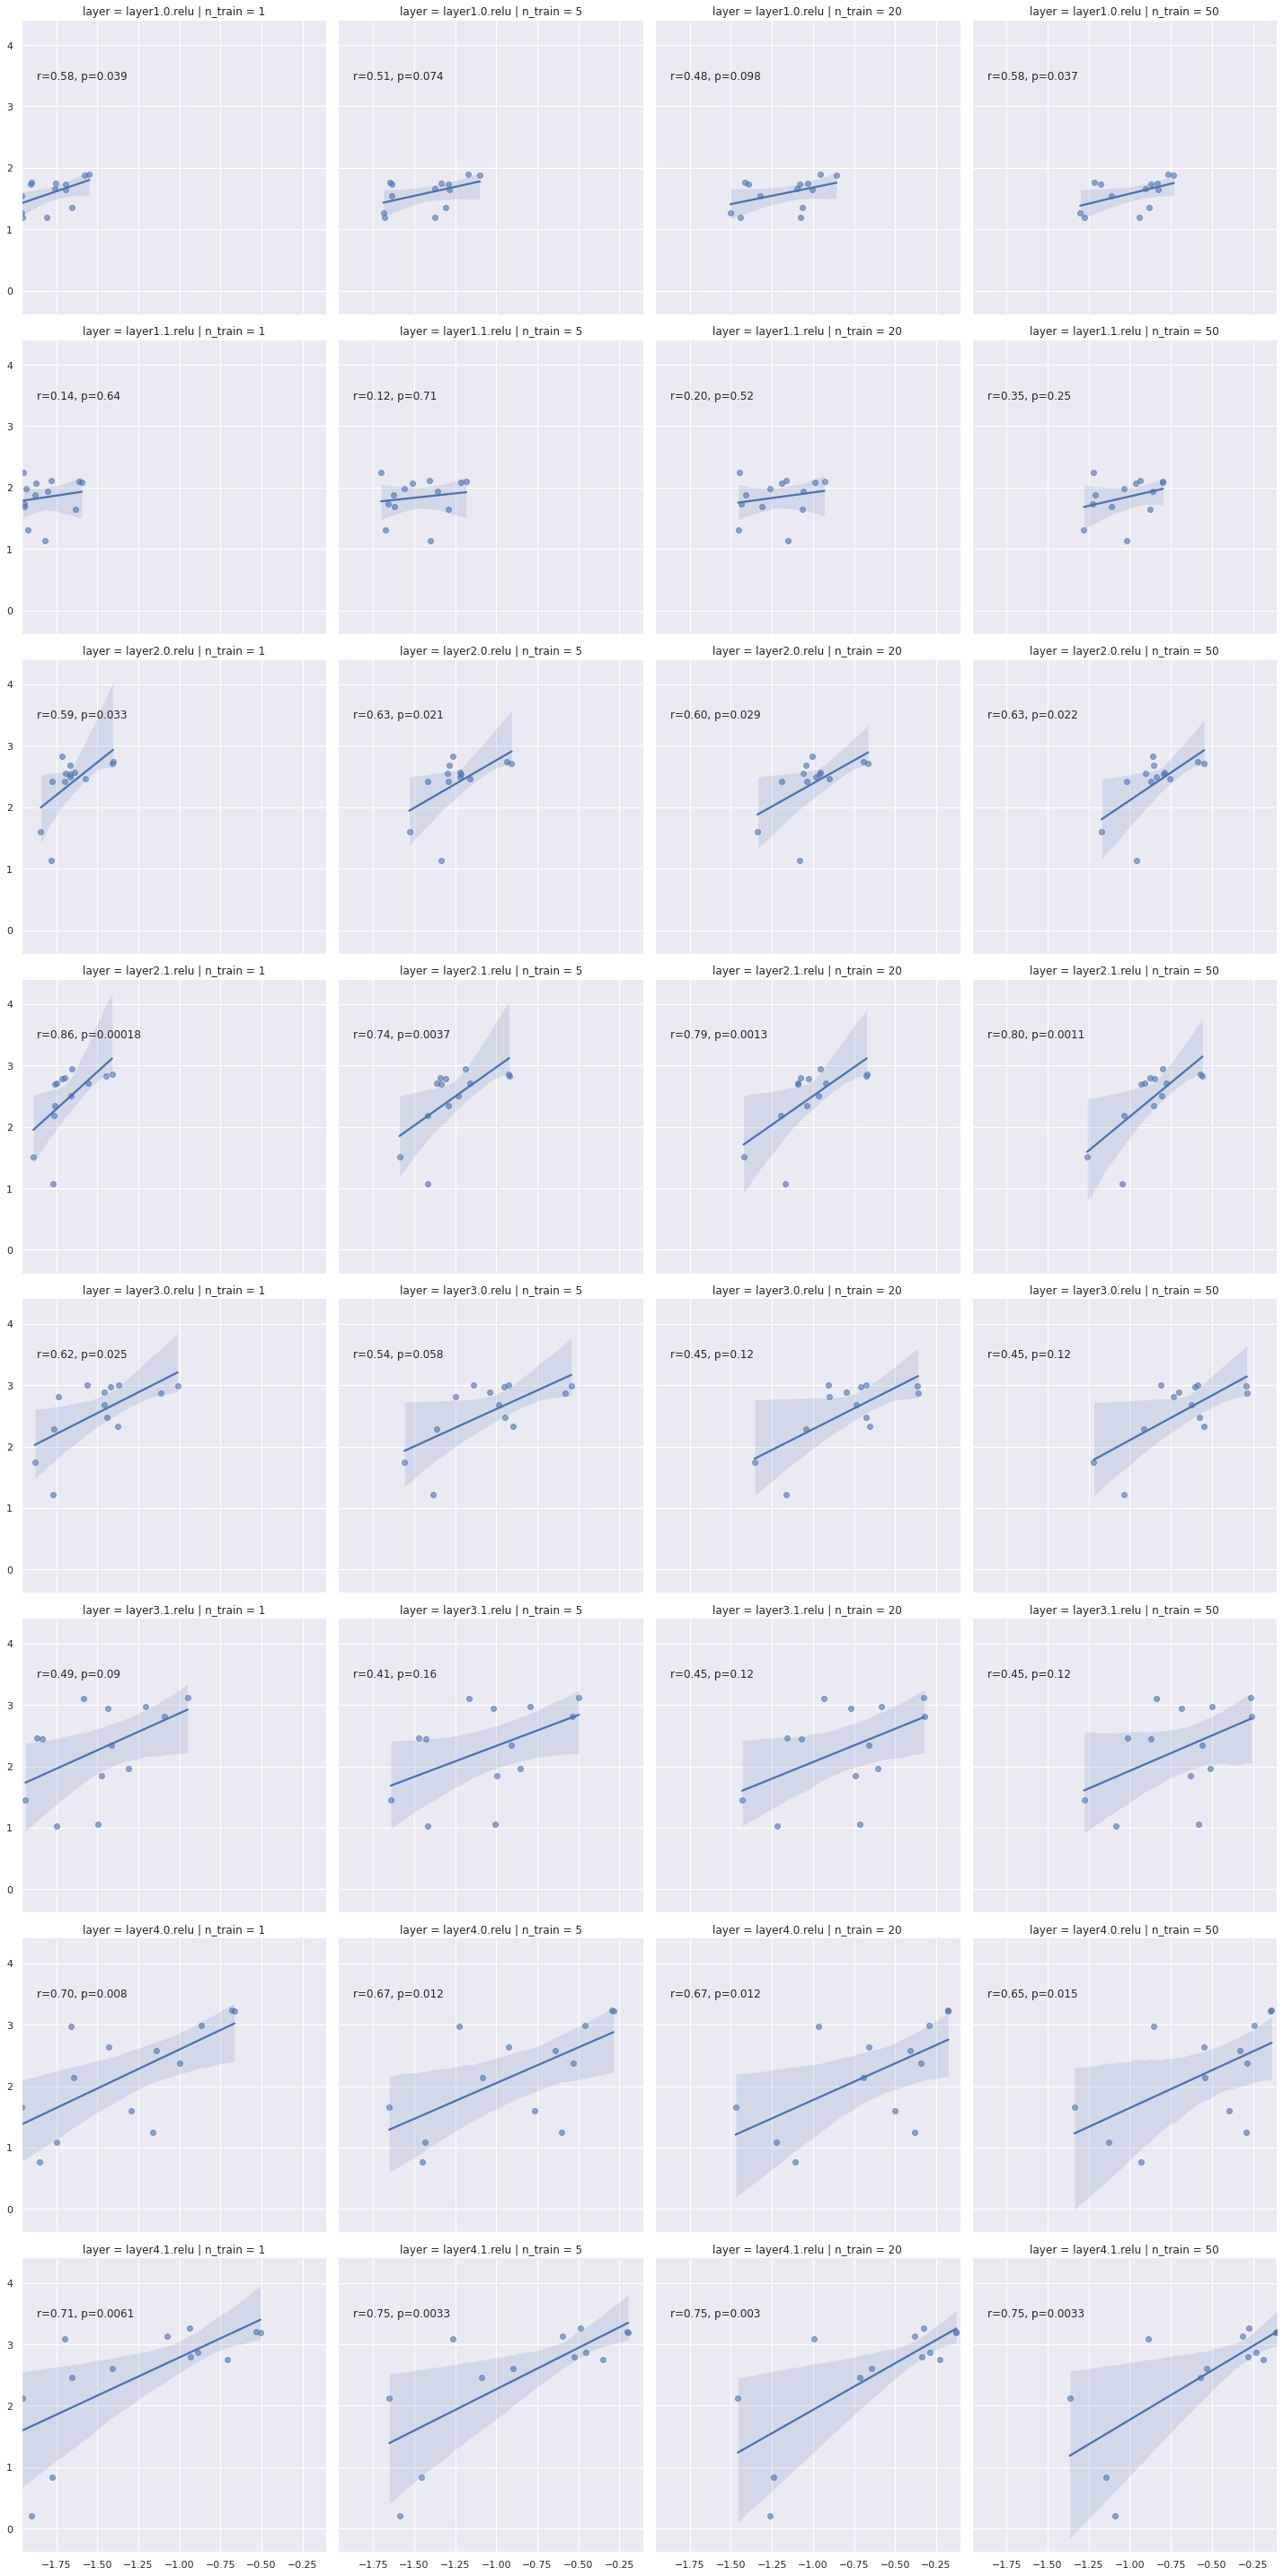

In [14]:
results = data_cd[(data_cd.architecture == 'ResNet18')]
g = sns.lmplot(data=results, x=metric_nshot, y=metric_man, col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric_nshot, y=metric_man)
plt.show()

## Taskonomy (ResNet 50)

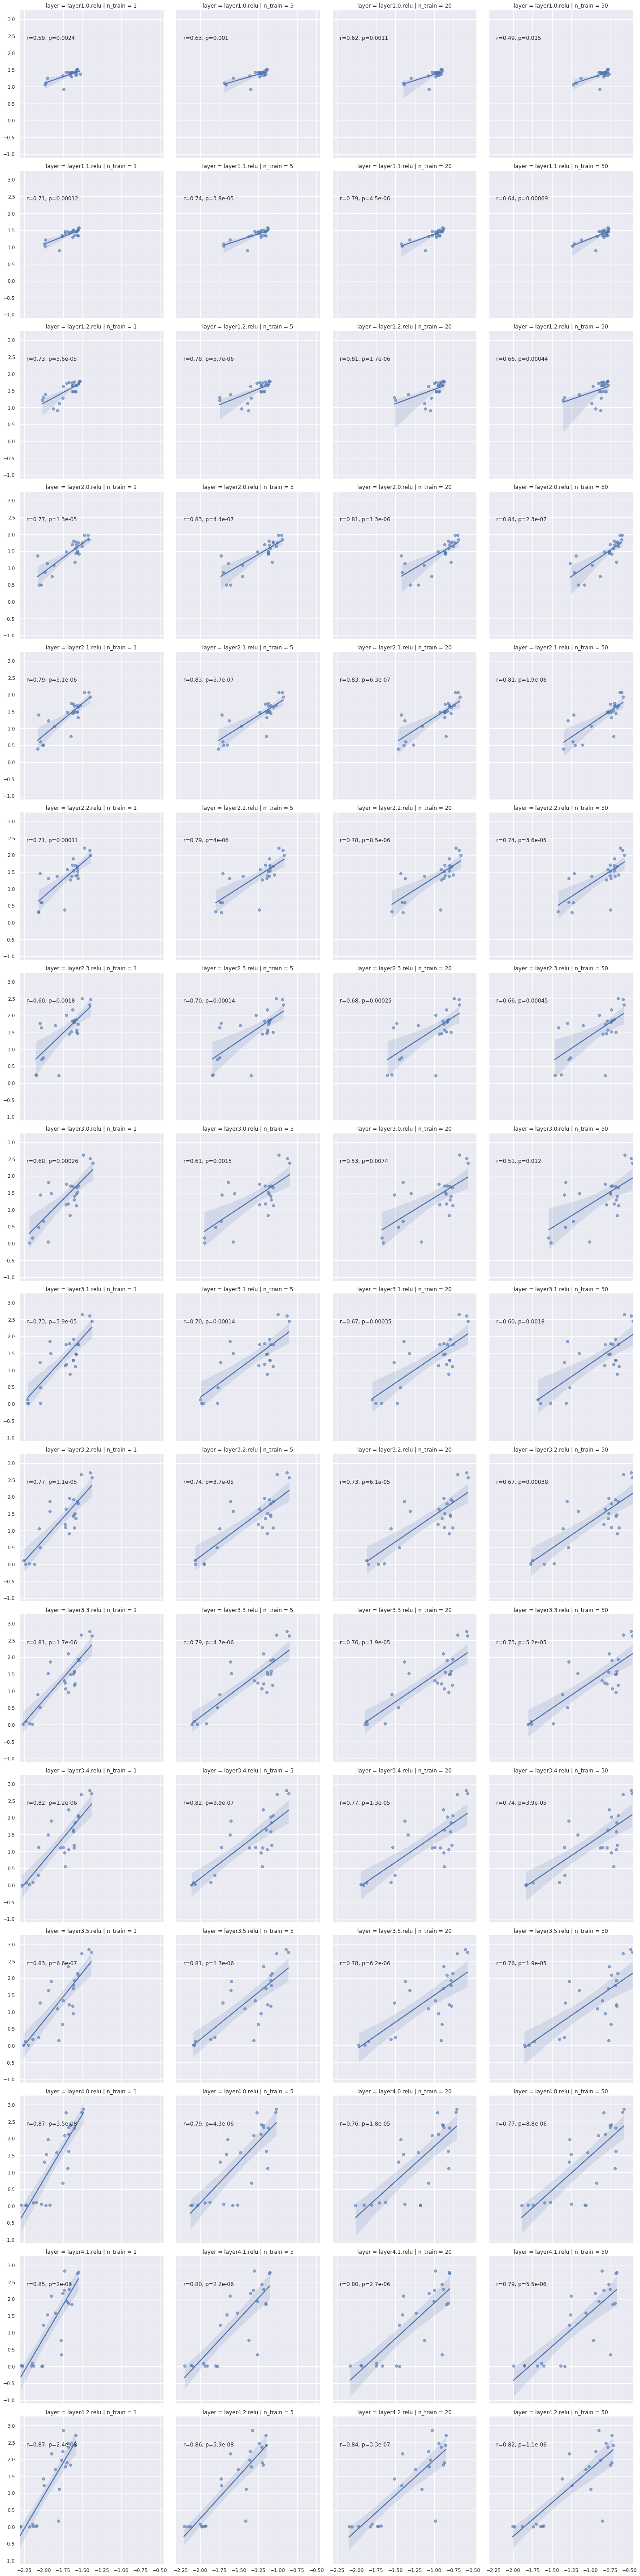

In [15]:
results = data_cd[(data_cd.source == 'Taskonomy')]
g = sns.lmplot(data=results, x=metric_nshot, y=metric_man, col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=True, sharey=True, height=5)
annotate_corr_grid(g, x=metric_nshot, y=metric_man)
plt.show()